# Home Assignment 1
Due by 8th May, 2024 at 23:59 CEST

Students:
* Hauke Schüle, 10004972
* Jannik Jahn, 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Neural Network Basics

We want to create a 2 layer NN, which means we want to calculate  $y = W_2 * ReLU(W_1 * x + b_1) + b_2$

Complete the TODOs below to create such a NN.

Since you will be needing to compute the gradients w.r.t. all parameters, you may look into online resources for help. Please cite or link any online recources you do use.

You are allowed to change any existing parts, however the code has to remain easy to understand and well documented.

In [2]:
def relu(x):
    """
    ReLU activation function
    
    Parameters:
        x (np.ndarray): numpy array with shape (m, n) where m is the number of dimensions and n is the number of points
        
    Returns:
        x' (np.ndarray): return value of the pointwise ReLU application
    """
    r = x.copy()
    for element in np.nditer(r, op_flags=['readwrite']):
        if element < 0:
            element[...] = 0
        else:
            element[...] = element
    return r


def relu_grad(x):
    r_grad = x.copy()
    for element in np.nditer(r_grad, op_flags=['readwrite']):
        if element <= 0:
            element[...] = 0
        else:
            element[...] = 1
    return r_grad

def sigmoid(x):
    """
    Sigmoid activation function
    Parameters:
        x (np.ndarray): numpy array with shape (m, n) where m is the number of dimensions and n is the number of points
    Returns:
        x' (np.ndarray): return value of the pointwise sigmoid application
    """
    return 1 / (1 + np.exp(-x))

In [3]:
class NumPyNeuralNet:
    
    def __init__(self, dim_in, dim_hidden, dim_out):
        self.dim_in = dim_in
        self.dim_hidden = dim_hidden
        self.dim_out = dim_out
        
        self.W_1 = np.random.randn(dim_in, dim_hidden) # weight matrix for first layer
        self.W_2 = np.random.randn(dim_hidden, dim_out) # weight matrix for second layer
        self.b_1 = np.random.randn(1, dim_hidden) # bias for first layer, shape (1, n) for easy matrix addition
        self.b_2 = np.random.randn(1, dim_out) # bias for second layer, shape (1, n) for easy matrix addition
        
        
    def predict(self, x):
        """
        Calculates the output of the neural network for the given x.
        
        Parameters:
            x (np.ndarray): input value numpy array
        
        Returns:
            y (np.ndarray): predicted output for `x`
        """
        if x.shape != (1, self.dim_in):
            raise ValueError(f"Input dimension {x.shape} does not match the expected input dimension {(1, self.dim_in)}")
        hidden = relu((x @ self.W_1) + self.b_1)
        output = hidden @ self.W_2 + self.b_2
        return output
    
    
    def loss(self, x, y):
        """
        Calculates the Mean-Squared Error and returns the gradients w.r.t. to the parameters.
        
        Parameters:
            x (np.ndarray): input value numpy array with shape (self.dim_in, n)
            y (np.ndarray): ground truth value numpy array with shape (self.dim_out, n)
            
        Returns:
            loss (float): Mean-Squared-Error between predicted value on input points and ground truth value
            W_1_grad (np.ndarray): gradient w.r.t W_1   
            W_2_grad (np.ndarray): gradient w.r.t W_2  
            b_1_grad (np.ndarray): gradient w.r.t b_1   
            b_2_grad (np.ndarray): gradient w.r.t b_2   
        """
        # make sure that the input and output dimensions are correct
        if x.shape != (1, self.dim_in):
            raise ValueError(f"Input dimension {x.shape} does not match the expected input dimension {(1, self.dim_in)}")
        if y.shape != (1, self.dim_out):
            raise ValueError(f"Ground truth dimension {y.shape} does not match the expected output dimension {(1, self.dim_out)}")
        y_pred = self.predict(x)

        if y_pred.shape != y.shape:
            raise ValueError(f"Predicted shape {y_pred.shape} does not match the expected shape {y.shape}")
        
        # calculate the loss
        loss = 0.5 * np.mean(np.square(y_pred - y)) # Mean Squared Error with 1/2 factor for easier gradient calculation
        
        # calculate the gradients
        l_grad = y_pred - y # gradient of the loss w.r.t. the output
        h = x @ self.W_1 + self.b_1
        r = relu(h)
        r_grad = relu_grad(h)

        b_2_grad = np.array(l_grad)
        W_2_grad = r.T @ l_grad
        b_1_grad = l_grad @ self.W_2.T * r_grad
        W_1_grad = x.T @ (l_grad @ self.W_2.T * r_grad)

        return loss, W_1_grad, W_2_grad, b_1_grad, b_2_grad

    
    def update(self, W_1_grad, W_2_grad, b_1_grad, b_2_grad, lr=0.001):
        """
        Update the parameters of the neural network with the gradients.
        
        Parameters:
            W_1_grad (np.ndarray): gradient w.r.t W_1
            W_2_grad (np.ndarray): gradient w.r.t W_2
            b_1_grad (np.ndarray): gradient w.r.t b_1
            b_2_grad (np.ndarray): gradient w.r.t b_2
            lr (float): learning rate, default: 0.001
        """
        self.W_1 -= lr * W_1_grad
        self.W_2 -= lr * W_2_grad
        self.b_1 -= lr * b_1_grad
        self.b_2 -= lr * b_2_grad

         
    def train(self, x, y, lr=0.001, epochs=1000):
        """
        Train the neural network with gradient descent.
        
        Parameters:
            x (np.ndarray): input values
            y (np.ndarray): ground truth values
            lr (float): learning rate, default: 0.001
            epochs (int): number of epochs to train, default: 1000
            
        Returns:
            loss (float): Return the loss achieved after all epochs
        """
        loss_history = []
        # for every epoch
        for i in range(epochs):
            # for every sample in the dataset
            loss_eopch = [] # plot the mean loss for every epoch
            for j in range(x.shape[0]): # x shape is to be expected as (n, 1, dim_in). n samples in the dataset with the extra dimension for easier matrix multiplication
                x_j = x[j]
                y_j = y[j]
                loss, W_1_grad, W_2_grad, b_1_grad, b_2_grad = self.loss(x_j, y_j)
                self.update(W_1_grad, W_2_grad, b_1_grad, b_2_grad, lr)
                loss_eopch.append(loss)
            loss_history.append(np.mean(loss_eopch))
        plt.plot(loss_history)
        plt.ylabel("Loss")
        plt.xlabel("Epochs")
        plt.title("Average Loss over epochs")
        plt.show()
        return loss # return the final loss



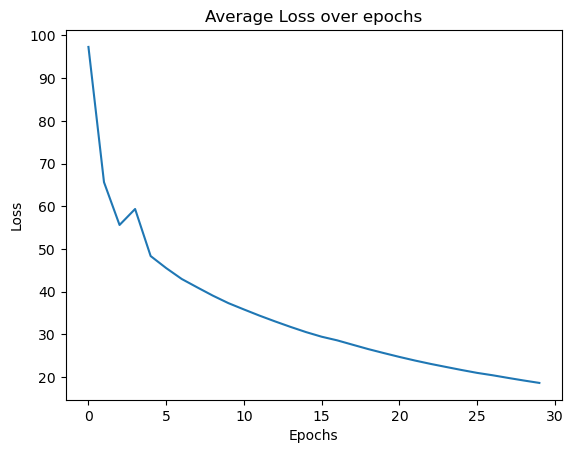

Final loss: 0.829838943588681


In [4]:
# We test the model created above on the simple function y = x^2

model = NumPyNeuralNet(1, 20, 1)

# Create a randomly distributed array of 1000 values
x_train = 4 * np.random.randn(100, 1, 1)
# Create ground truth by calculating x*x
y_train = np.expand_dims([[x_train[i][0][0] * x_train[i][0][0]] for i in range(x_train.shape[0])], axis=1)

loss = model.train(x_train, y_train, lr=0.001, epochs=30)
print(f"Final loss: {loss}")

# 1000 samples with 1000 epochs work, but *10 is too large values. I suspect that the weights are too large
# and then we get overflow errors. But with *4 it works quite well.

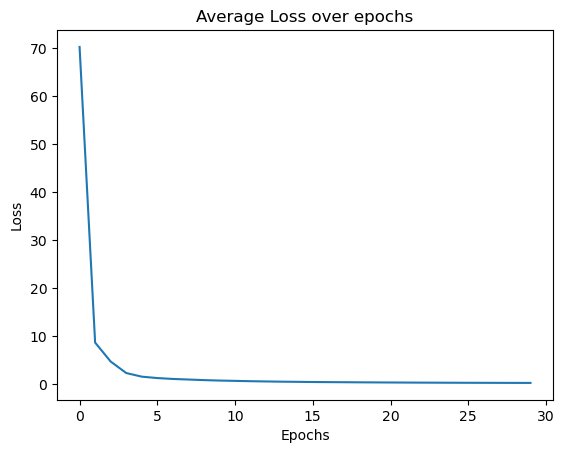

x_train shape: (50, 1, 4)
y_train shape: (50, 1, 2)
y_train: [[[ 1.12291779e+00  5.79694631e+00]]

 [[ 7.53420250e+00 -4.42961695e+00]]

 [[ 6.45645075e+00 -5.65393191e+00]]

 [[ 8.24325609e+00  2.29305279e+00]]

 [[ 6.32063335e+00  2.34433178e+00]]

 [[ 1.20312818e+00 -3.78501803e+00]]

 [[-1.04852933e+01  2.59332884e+00]]

 [[-1.52478798e+00  5.08606899e+00]]

 [[-3.11971909e+00  1.72375909e+00]]

 [[ 1.29236267e+01  4.33436033e+00]]

 [[-9.65846840e+00  9.06907749e-01]]

 [[-1.19210620e+01 -4.55020780e-01]]

 [[ 4.64205506e+00  5.11509671e+00]]

 [[ 1.72773923e+00 -1.88205787e+00]]

 [[-4.63775545e+00  9.08596476e+00]]

 [[ 4.51883510e+00 -5.48726249e-01]]

 [[ 6.90701873e+00 -1.67666049e+00]]

 [[ 3.17752291e+00  5.01393358e+00]]

 [[ 4.30037831e+00 -4.54058982e+00]]

 [[ 2.07059325e+00  5.73398894e+00]]

 [[ 7.95457477e+00 -7.13215284e+00]]

 [[ 3.03123064e+00 -3.68642627e+00]]

 [[-1.71689437e+00  1.36695152e+00]]

 [[ 3.57862481e+00 -3.75262947e+00]]

 [[ 5.80321617e+00 -1.00451

In [5]:
# test the model on more than one input dimension and with reasonable number of epochs and samples on a simple function

model = NumPyNeuralNet(4, 20, 2)

x_train = 4 * np.random.randn(50, 1, 4)
y_train = np.expand_dims([[x_train[i][0][0] + x_train[i][0][1], x_train[i][0][2] + x_train[i][0][3]] for i in range(x_train.shape[0])], axis=1)

loss = model.train(x_train, y_train, lr=0.001, epochs=30)
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_train: {y_train}")
x_test = 2 * np.random.randn(1, 4)
y_test = np.array([[x_test[0][0] + x_test[0][1], x_test[0][2] + x_test[0][3]]])
print(f"x_test {x_test}")
print(f"Predicted: {model.predict(x_test)}")
print(f"Expected: {y_test}")
print(f"Final loss: {loss}")

## Embeddings

### Intrinsic evaluation of embeddings
Word similarity task is often used as an intrinsic evaluation criteria. In the dataset file you will find a list of word pairs with their similarity scores as judged by humans. The task would be to judge how well are the word vectors aligned to human judgement. We will use word2vec embedding vectors trained on the google news corpus. (Ignore the pairs where at least one the words is absent in the corpus)

In [8]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

Write a function which takes as input two words and computes the cosine similarity between them.
You do not need to implement the cosine similarity calculation from scratch. Feel free to use any Python library.
Remeber to ignore any pairs where at least one word is absent in the corpus. (2 points)

In [23]:
def similarity(word1, word2):
    """
    Calculate the cosine similarity between two words.
    
    Parameters:
        word1 (str): first word
        word2 (str): second word
        
    Returns:
        sim (float): cosine similarity between the two words
    """
    if word1 not in wv.key_to_index or word2 not in wv.key_to_index:
        return None
    sim = cosine_similarity(wv[word1].reshape(1, -1), wv[word2].reshape(1, -1))
    return sim[0][0]

Compute the similarity between all the word pairs in the list and sort them based on the similarity scores. (1 point)

In [ ]:
df.sort_values(by='similarity_score', ascending=False, inplace=True)
word_pairs_cosine_similarity = list(zip(df['word_1'].tolist(), df['word_2'].tolist()))
print(word_pairs_cosine_similarity[:10])

[('tiger', 'tiger'), ('Harvard', 'Yale'), ('man', 'woman'), ('football', 'soccer'), ('mile', 'kilometer'), ('vodka', 'brandy'), ('journey', 'voyage'), ('football', 'basketball'), ('type', 'kind'), ('championship', 'tournament')]


Sort the word pairs in the list based on the human judgement scores. (1 point)

In [31]:
df.sort_values(by='human_mean', ascending=False, inplace=True)
word_pairs_human_mean = list(zip(df['word_1'].tolist(), df['word_2'].tolist()))
print(word_pairs_human_mean[:10])

[('tiger', 'tiger'), ('fuck', 'sex'), ('midday', 'noon'), ('journey', 'voyage'), ('dollar', 'buck'), ('money', 'cash'), ('coast', 'shore'), ('money', 'cash'), ('money', 'currency'), ('football', 'soccer')]


Compute spearman rank correlation between the two ranked lists obtained in the previous two steps.
You do not need to implement the spearman rank correlation calculation from scratch. Feel free to use any Python library. (2 points)

In [32]:
print(f"len word_pairs_cosine_similarity: {len(word_pairs_cosine_similarity)}")
print(f"len word_pairs_human_mean: {len(word_pairs_human_mean)}")

len word_pairs_cosine_similarity: 353
len word_pairs_human_mean: 353


### Word embedding based clasifier
We will design a simple sentiment classifier based on the pre-trained word embeddings (google news).

Each data point is a movie review and the sentiment could be either positive (1) or negative (0)

In [82]:
import pickle
with open('sentiment_test_X.p', 'rb') as fs:
    test_X = pickle.load(fs)

len(test_X)

1821

In [83]:
test_X[0]

['If',
 'you',
 'sometimes',
 'like',
 'to',
 'go',
 'to',
 'the',
 'movies',
 'to',
 'have',
 'fun',
 ',',
 'Wasabi',
 'is',
 'a',
 'good',
 'place',
 'to',
 'start',
 '.']

In [84]:
with open('sentiment_test_y.p', 'rb') as fs:
    test_y = pickle.load(fs)
    
len(test_y)

1821

In [85]:
test_y[0]

1

In [86]:
with open('sentiment_train_X.p', 'rb') as fs:
    train_X = pickle.load(fs)
with open('sentiment_train_y.p', 'rb') as fs:
    train_y = pickle.load(fs)
with open('sentiment_val_X.p', 'rb') as fs:
    val_X = pickle.load(fs)
with open('sentiment_val_y.p', 'rb') as fs:
    val_y = pickle.load(fs)        

Given a review, compute its embedding by averaging over the embedding of its constituent words. Define a function which given a review as a list of words, generates its embeddings by averaging over the constituent word embeddings. (4 points)

In [87]:
def generate_embedding(review):
    # return embedding
    pass

Create a feed-forward network class with pytorch. (Hyperparamter choice such as number of layers, hidden size is left to you) (8 points)

In [88]:
class Classifier(nn.Module):
    pass

Create a Dataset class for efficiently enumerating over the dataset. (3 points)

In [89]:
class sent_data(Dataset):
    def __init__(self):
        pass
    
    def __len__(self):
        pass
    
    def __getitem__(self):
        pass

Write a train function to train model. At the end of each epoch compute the validation accuracy and save the model with the best validation accuracy. (12 points)

In [90]:
# Adopt your code to incorporate mini-batch training
# Use cross-entropy as your loss function
def train(model, train_data, val_data, epochs=5, learning_rate=0.001):
    # write your code snippet here
    
    pass

Evaluate the trained model on the test set and report the test accuracy. (3 points)

In [91]:
def evaluate(model, test_data):
    pass